In [2]:
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt
from torch.nn import Parameter
from torch.optim import Adam
from gpytorch.optim import NGD
from gpytorch.constraints import Positive, Interval

from alfi.models import OrdinaryLFM, MultiOutputGP #MLPLFM
from alfi.utilities.torch import inv_softplus, softplus
from alfi.datasets import DeterministicLotkaVolterra
from alfi.plot import Plotter1d, plot_phase, Colours
from alfi.configuration import VariationalConfiguration
from alfi.trainers import VariationalTrainer

import os 
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))

from data import PVDataGenerator, PV_LFM_Dataset
from data.utils import *
from data import PV_LFM_Dataset
from models import LotkaVolterra

f64 = np.float64

/Users/eirikbaekkelund/opt/anaconda3/envs/lfm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 2
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6

num_tasks = 1
num_latents = 1
num_inducing = 100

In [4]:
generator = PVDataGenerator(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

X, y = generator.get_time_series()
x_train, y_tr, x_test, y_te = train_test_split(X, y, hour=12)

y_train = y_tr[:,3:4]
y_test = y_test[:,3:4]

f_observed = y_tr[:,2]

==> Loading data
==> Loaded data in: 0 m : 14 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



NameError: name 'y_test' is not defined

In [ ]:
t_train = torch.linspace(0, 100, len(y_train))

In [ ]:
dataset = PV_LFM_Dataset(num_outputs=num_tasks, 
                         m_observed=y_train,
                         f_observed=f_observed, 
                         train_t=t_train,
                         variance= 0.01 * torch.ones(num_tasks, dtype=torch.float64))

In [ ]:
x_min, x_max = dataset.t_observed.min(), dataset.t_observed.max()
num_training = len(dataset.t_observed)

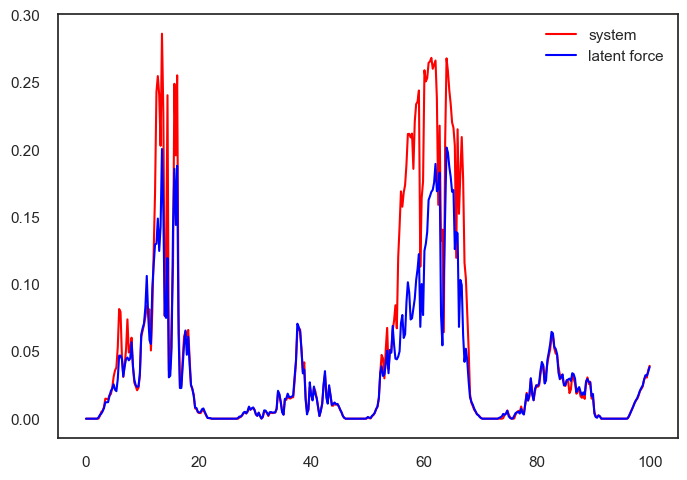

In [ ]:
plt.rcParams['font.family'] = 'Arial'

plt.plot(dataset.data[0][0], dataset.data[0][1], c='red', label='system')
plt.plot(torch.linspace(x_min, x_max, dataset.f_observed.shape[0]), dataset.f_observed, c='blue', label='latent force')
plt.legend()
output_names = dataset.names

In [ ]:
from gpytorch.constraints import Positive, Interval
from torch.nn import Parameter
from alfi.utilities.torch import softplus, inv_softplus

class LotkaVolterra(OrdinaryLFM):
    """Outputs are PV. Latents are prey"""
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        self.positivity = Positive()
        self.decay_constraint = Interval(0., 100)
        self.raw_decay = Parameter(self.decay_constraint.inverse_transform(torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_growth = Parameter(self.positivity.inverse_transform(0.5*torch.ones(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        self.raw_initial = Parameter(self.positivity.inverse_transform(0.3+torch.zeros(torch.Size([self.num_outputs, 1]), dtype=torch.float64)))
        print(dataset.f_observed.shape)
        self.true_f = dataset.f_observed[::1].unsqueeze(0).repeat(self.config.num_samples, 1).unsqueeze(1)
        print(self.true_f.shape)
        
    @property
    def decay_rate(self):
        return self.decay_constraint.transform(self.raw_decay)

    @decay_rate.setter
    def decay_rate(self, value):
        self.raw_decay = self.decay_constraint.inverse_transform(value)

    @property
    def growth_rate(self):
        return softplus(self.raw_growth)

    @growth_rate.setter
    def growth_rate(self, value):
        self.raw_growth = inv_softplus(value)

    @property
    def initial_predators(self):
        return softplus(self.raw_initial)

    @initial_predators.setter
    def initial_predators(self, value):
        self.raw_initial = inv_softplus(value)

    def initial_state(self):
        return self.initial_predators

    def odefunc(self, t, h):

        self.nfe += 1

        f = self.f[:, :, self.t_index].unsqueeze(2)
        dh = self.growth_rate * h * f - self.decay_rate * h

        if t > self.last_t:
            self.t_index += 1
        self.last_t = t

        # take mean of MC samples if using non-Gaussian likelihood for the gp model
        if not isinstance(self.gp_model.likelihood, gpytorch.likelihoods.GaussianLikelihood):
            return dh.mean(dim=1, keepdim=True)
        
        return dh

    def G(self, f):
        # I = 1 so just repeat for num_outputs
        #softplus
        return softplus(f).repeat(1, self.num_outputs, 1)

In [ ]:
from gpytorch.means import ConstantMean, ZeroMean
from kernels import Kernel
from likelihoods import MultitaskBetaLikelihood
from models import MultitaskGPModel


mean = ConstantMean(batch_shape=torch.Size([num_latents]))
likelihood = MultitaskBetaLikelihood(num_tasks=num_tasks, 
                                     batch_shape=torch.Size([num_latents]),
                                     scale=30)

kernel_module = Kernel(num_latent=num_latents)
matern_base = kernel_module.get_matern()
matern_quasi = kernel_module.get_matern()
periodic1 = kernel_module.get_periodic()

quasi_periodic = kernel_module.get_quasi_periodic(matern_base, matern_quasi, periodic1)

In [ ]:
# inducing_points = torch.linspace(x_min, x_max, num_inducing).repeat(num_latents, 1).view(
#     num_latents, num_inducing, 1)

model = MultitaskGPModel(X=x_train,
                         y=y_train,
                         likelihood=likelihood,
                         mean_module=mean,
                         covar_module=quasi_periodic,
                         num_latents=num_latents,
                         jitter=1e-4)

/Users/eirikbaekkelund/opt/anaconda3/envs/lfm/lib/python3.9/site-packages/alfi/models/variational_lfm.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


torch.Size([409])
torch.Size([70, 1, 409])


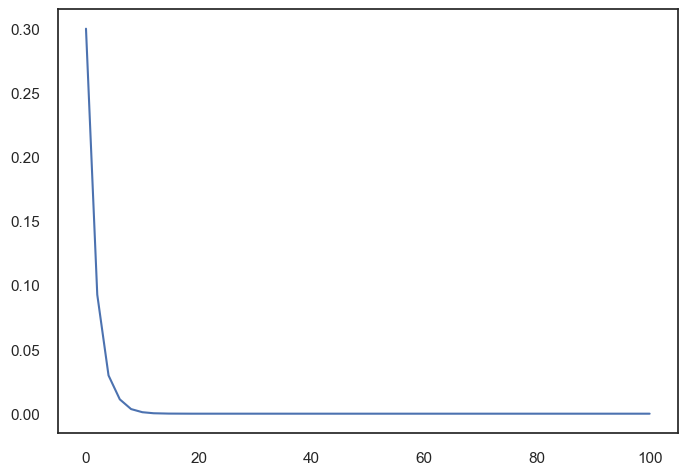

In [ ]:
config = VariationalConfiguration(num_samples=70)

    
t_predict = torch.linspace(0, x_max, 151, dtype=torch.float32)


lfm = LotkaVolterra(num_tasks, model, config, num_training_points=num_training)

plotter = Plotter1d(lfm, np.array(['predator']))
plt.rcParams['font.family'] = 'Arial'

out = lfm(t_predict, step_size=2)
plt.plot(t_predict, out.mean.detach())

In [ ]:
optimizers = [torch.optim.Adam(lfm.parameters(), lr=0.02)]

trainer = VariationalTrainer(
    lfm,
    optimizers,
    dataset,
    warm_variational=100,
)

In [ ]:
a = trainer.train(200, report_interval=10, step_size=2)

Epoch 001/200 - Loss: 1.09 (1.09 0.00) kernel: 
Epoch 011/200 - Loss: 1.01 (1.01 0.00) kernel: 
Epoch 021/200 - Loss: 0.94 (0.94 0.00) kernel: 
Epoch 031/200 - Loss: 0.85 (0.85 0.00) kernel: 
Epoch 041/200 - Loss: 0.77 (0.77 0.00) kernel: 
Epoch 051/200 - Loss: 0.68 (0.68 0.00) kernel: 
Epoch 061/200 - Loss: 0.59 (0.59 0.00) kernel: 
Epoch 071/200 - Loss: 0.50 (0.50 0.00) kernel: 
Epoch 081/200 - Loss: 0.40 (0.40 0.00) kernel: 
Epoch 091/200 - Loss: 0.31 (0.31 0.00) kernel: 
Epoch 101/200 - Loss: 0.21 (0.21 0.00) kernel: 
Epoch 111/200 - Loss: 0.11 (0.11 -0.00) kernel: 
Epoch 121/200 - Loss: 0.01 (0.01 0.00) kernel: 
Epoch 131/200 - Loss: -0.09 (-0.09 0.00) kernel: 
Epoch 141/200 - Loss: -0.18 (-0.18 0.00) kernel: 
Epoch 151/200 - Loss: -0.28 (-0.28 0.00) kernel: 
Epoch 161/200 - Loss: -0.37 (-0.37 0.00) kernel: 
Epoch 171/200 - Loss: -0.42 (-0.44 0.01) kernel: 
Epoch 181/200 - Loss: -0.46 (-0.50 0.05) kernel: 
Epoch 191/200 - Loss: -0.52 (-0.58 0.05) kernel: 


In [ ]:
x = dataset.data[0][0]
y = dataset.data[0][1]

In [ ]:
lfm.eval()
t_interval = (0, 150)
t_predict = torch.linspace(*t_interval, 100, dtype=torch.float32)
t_scatter = dataset.data[0][0].unsqueeze(0).unsqueeze(0)
y_scatter = dataset.data[0][1].unsqueeze(0).unsqueeze(0)

q_m = lfm.predict_m(t_predict, step_size=3)
q_f = lfm.predict_f(t_predict)

ylim = (-0.01, 1)

fig, axes = plt.subplots(ncols=2,
                         figsize=(8, 3),
                         gridspec_kw=dict(width_ratios=[3, 1]))
plotter.plot_gp(q_m, t_predict, num_samples=0,
                t_scatter=t_scatter,
                y_scatter=y_scatter,
                ylim=ylim,
                titles=None, ax=axes[0])
axes[0].set_xlabel('Time')
axes[0].set_ylabel('PV power')
axes[0].set_xlim(*t_interval)

plotter.plot_gp(q_f, t_predict,
                transform=softplus,
                color=Colours.line2_color,
                shade_color=Colours.shade2_color,
                ylim=ylim,
                titles=None, ax=axes[0])


axes[0].set_xlabel('Time')
axes[0].set_ylabel('PV Output (0-1 Scale)')
axes[0].plot(dataset.times, dataset.f_observed, c=Colours.scatter_color, label='Target')
axes[0].set_xticks([t_predict[0], t_predict[-1]])

axes[0].set_yticks([ylim[0], ylim[1]])
axes[0].fill_between(t_scatter.squeeze(), ylim[0], ylim[1], alpha=0.2, color='gray')
axes[0].get_lines()[0].set_label('Predator')
axes[0].get_lines()[1].set_label('Prey')
axes[0].legend()

lfm.gp_model.eval()
lfm.gp_model(t_predict)

with torch.no_grad():
    pv_latent = lfm.gp_model.likelihood((lfm.gp_model(t_predict)))
    pv_predicted = lfm(t_predict)
pv = pv_latent.sample(torch.Size([30]))
latent = pv_predicted.mean

pv = pv.mean(axis=0).mean(axis=0)

axes[0].plot(t_predict, pv, c=Colours.line_color)
axes[0].plot(t_predict, latent, c=Colours.line2_color)



axes[1].set_yticks([0, 1])
plt.tight_layout()
